In this notebook, we perform the data assimilation of pressure observations collected on the surface of a flat plate at $20$ degrees of angle of attack . 

More details on the numerical experiment can be found in Le Provost, M., & Eldredge, J. D. (2021). Ensemble Kalman filter for vortex models of disturbed aerodynamic flows. Physical Review Fluids, 6(5), 050506.

We compare the performance of the stochastic ensemble Kalman filter with the localized stochastic ensemble Kalman filter.

In [2]:
# Load libraries
using Revise
using TransportBasedInference
using LocalizedVortex
using PotentialFlow
import PotentialFlow.Plates: Plate
using Random
using ProgressMeter
using LinearAlgebra
using Statistics
using JLD
using Interpolations

In [33]:
# Load plotting libraries
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        grid = false)
pyplot()
using LaTeXStrings
using ColorSchemes

In [4]:
# Define colors
ccfd = colorant"navy blue"
cenkf = colorant"teal"
clocenkf = colorant"orangered2"
cgust = colorant"limegreen"
ctmap = colorant"purple"

Load truth pressure observations from high fidelity numerical simulations at $Re = 500$.

In [5]:
thist, Fn, data, X̃, Δt, xg, yg = load("/media/mat/HDD/VortexModels/CFD_generation/Results/flat_plate_convective_2gusts_06.jld",
                              "thist","Fn","pressure", "Xtilde", "dt", "xg", "yg");
Δs = mean(X̃[2:end]-X̃[1:end-1]);
T = range(thist[50], stop = thist[end], length = 100)
s = X̃[1]:Δs:X̃[end]

# Define space and time interpolated surface pressure field
pressure_data = CubicSplineInterpolation((s, T), reverse(hcat(data[50:50:end]...), dims = 1), 
                                          extrapolation_bc =  Line());

In [11]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 5e-3, Δt = 1e-2, 
             tesp = 0.0,
             ϵX = 1e-5, ϵΓ = 1e-5, ϵLESP = 5e-5,
             β = 1.0,
             ϵY = 1e-5
    VortexParams(N, L, ċ, α, δ, Δt, true, tesp, ϵX, ϵΓ, ϵLESP, β, ϵY)
end

VortexParams(512, 1.0, 1.0 + 0.0im, 0.3490658503988659, 0.005, 0.01, true, 0.0, 1.0e-5, 1.0e-5, 5.0e-5, 1.0, 1.0e-5)

In [24]:
tf = 5.0
pressure_taps = 10:10:config.N-10
T = 0:config.Δt:tf

0.0:0.01:5.0

x-t diagram of the pressure field along the airfoil 

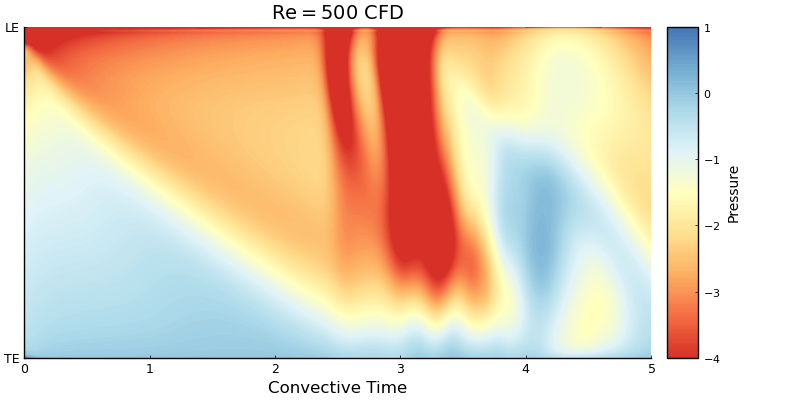

In [13]:
sch = ColorSchemes.RdYlBu_9.colors
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    #model_pressures = hcat((measure_state(mean(states[i+1]), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    cfd_pressures = 2hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)
    plt = plot(size = (800, 400))
    contourf!(T, s, cfd_pressures, title = ["\$\\mathrm{Re} = 500\$ CFD" "EnKF Mean"],
        levels = range(-4.0, stop = 1, length = 161), clims = (-4, 1), color = cgrad(sch), xlabel = "Convective Time",
        #levels = linspace(-2, 2, 151), clims = (-2, 0.5), color = cgrad(reverse(colormap(:rainbow))), xlabel = ["Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = sch[1],colorbar_title="Pressure")
        #yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap(:rainbow)[end], colorbar_title="Pressure")
#     contour!(T, s, cfd_pressures,levels=0.0:0.0, color = PlotUtils.get_colorscheme(:grays)[1])
end

## Model Formulation

We have a flat plate that is translating at a fixed angle of attack and velocity.
We also use a constant blob radius on all of our vortex elements

In [28]:
config = let N = 512, L = 1.0, ċ = 1.0,
             α = π/9, δ = 9e-3, Δt = 1e-2, 
             tesp = 0.0,
             ϵX = 1e-5, ϵΓ = 2e-5, ϵLESP = 8.5e-4, 
             β = 1.028,
             ϵY = 1e-4

    VortexParams(N, L, ċ, α, δ, Δt, true, tesp, ϵX, ϵΓ, ϵLESP, β, ϵY)
end

idxp = 10:10:config.N-10


Ne = 50
Nx = 1
Ny = size(idxp,1)

tspan = (0.0, 5.0)
ϵy = AdditiveInflation(zeros(Ny), config.ϵY)

enkf = StochEnKF(filter_state!, ϵy, config.Δt, config.Δt; isfiltered=true)

X0 = zeros(Ny+Nx, Ne)
m0 = 0.5
C0 = 0.05^2

X0[Ny+1,:] = m0 .+ sqrt(C0)*exactn(Ne);

Perform data assimilation with the stochastic ensemble Kalman filter.

In [29]:
Xf, Xa = vortexassim(enkf, deepcopy(X0), tspan,  config, idxp, pressure_data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


Perform data assimilation with the localized stochastic ensemble Kalman filter. We use two cut-off length scales: $L_{xy}$ for the cross-covariance matrix $\Sigma_{X, Y}$ and $L_{yy}$ for the covariance matrix $\Sigma_Y$. 

In [30]:
Lxy = 1.0
Lyy = 0.6

0.6

In [31]:
Xf_loc, Xa_loc = localized_vortexassim(enkf, Lxy, Lyy, deepcopy(X0), tspan,  config, idxp, pressure_data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


Compare the performance of the sEnKF and the localized sEnKF

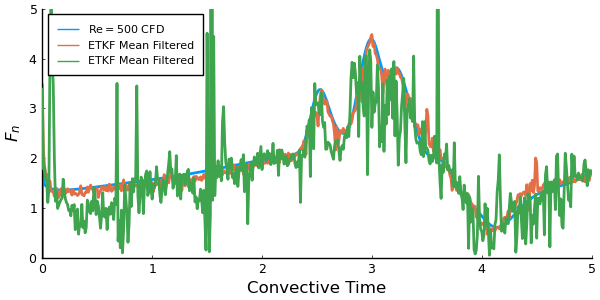

In [32]:
# Generate normal force response
f_enkf = regen_forces(T, map(Xi->vcat(mean(Xi; dims = 2), config.tesp), Xa), config)[1:end-1];
f_loc = regen_forces(T, map(Xi->vcat(mean(Xi; dims = 2), config.tesp), Xa_loc), config)[1:end-1];



plt = plot(thist, 2Fn, label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,tf), ylim = (0, 5), 
     linewidth = 2, legend = :topleft)

# # With median filtering
plot!(plt, T, 2*abs.(f_enkf), label = "sEnKF", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :solid)

plot!(plt, T, 2*abs.(f_loc), label = "Localized sEnKF", ylabel="\$F_n\$", xlabel = "Convective Time", size = (600, 300),
linewidth = 2, linestyle = :solid)

plt

In [33]:
@time covf = map(Xi -> cov(Xi; dims = 2), Xf[2:end]);
@time cova = map(Xi -> cov(Xi; dims = 2), Xa[2:end]);

  0.198290 seconds (503.42 k allocations: 68.891 MiB, 9.93% gc time, 83.50% compilation time)
  0.045085 seconds (77.03 k allocations: 45.078 MiB, 65.91% compilation time)


In [38]:
# Compare spatiotemporal pressure maps
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(vcat(mean(Xa[i+1]; dims = 2),config.tesp), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    filtmodel_pressures = hcat((cleansignal(7)(measure_state(vcat(mean(Xa[i+1]; dims = 2),config.tesp), t, config, pressure_taps)) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)

    plt = plot(layout = (3,1), size = (800, 600))
    contourf!(T, s, [cfd_pressures, model_pressures, filtmodel_pressures], 
        title = ["\$\\mathrm{Re} = 500\$ CFD" "ETKF Mean Non-filtered" "ETKF Filtered"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" "Convective Time"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title="Pressure")
end

In [35]:
plt = plot(xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
           xlim = (0, Inf), ylim = (0, 1.5))

plot!(plt, T, map(Xi ->mean(Xi; dims = 2)[end], Xa)[1:end-1])
plot!(T, map(Xi ->mean(Xi;dims = 2)[end], Xa_loc)[1:end-1], legend = false,
    xlabel = "Convective Time", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),)
# savefig("lespc_Ne"*string(Ne)*".pdf")

In [36]:
plot(T,  map(Xi ->(length(member(Xi,1))-2)/3, Xa[2:end]), linewidth = 2, size = (600, 200), 
    legend = false, xlim = (0, Inf),
    xlabel = "Convective Time", ylabel="Particle Count")

plot!(T,  map(Xi ->(length(member(Xi,1))-2)/3, Xa_loc[2:end]), linewidth = 2, size = (600, 200), 
    legend = false, xlim = (0, Inf),
    xlabel = "Convective Time", ylabel="Particle Count")

In [37]:
plt = plot(layout = (2,2), size = (800, 500), legend = false)
plot!(plt[1], T, map(cova) do P
        mean(diag(P)[1:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_x^2\$")
plot!(plt[2], T, map(cova) do P
        mean(diag(P)[2:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_y^2\$")
plot!(plt[3],T,  map(cova) do P
        mean(diag(P)[3:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\Gamma^2\$")
plot!(plt[4], T, map(cova) do P
        mean(diag(P)[end]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = "Convective Time",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$")

### Snapshot Figures

In [51]:
function translation!(b, d::ComplexF64)
    for (i, bi) in enumerate(b)
        b[i] = Vortex.Blob(bi.z+d, bi.S, bi.δ)
    end
    return b
end

translation! (generic function with 1 method)

In [52]:
plt = plot(ratio = 1.0, legned = false)
plot!(plt, Plate(config.N, config.L, complex(tsnap), config.α))
plot!(plt, state_to_blobs(vcat(mean(Xa[nsnap]; dims = 2), 0.0), config.δ)[1], legend = false,
    markersize = 8, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), clim = (-0.02, 0.02), 
    ratio = 1, xlim = (-1,tsnap+1.0), ylim = (-2,2),
    xticks = -1:0.5:tsnap+1.0, yticks = -2:0.5:2.0)

LoadError: UndefVarError: tsnap not defined

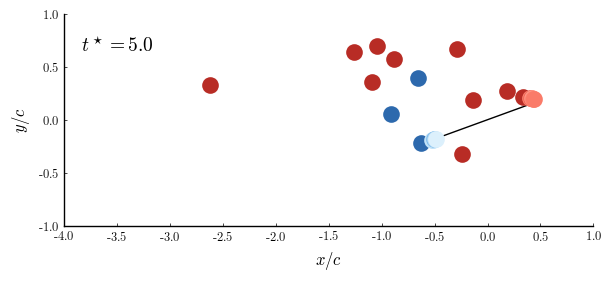

Animation("/tmp/jl_a6cP3S", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000092.png", "000093.png", "000094.png", "000095.png", "000096.png", "000097.png", "000098.png", "000099.png", "000100.png", "000101.png"])

In [41]:
anim = @animate for tsnap  in 0.0:0.05:5.0
    nsnap = ceil(Int64, tsnap/config.Δt)+1;

    plt = plot(ratio = 1.0, legend = false)
    plot!(plt, Plate(config.N, config.L, complex(0.0), config.α))
    plot!(plt, translation!(state_to_blobs(vcat(mean(Xa[nsnap]; dims = 2), 0.0), config.δ)[1], complex(-tsnap)), legend = false,
        markersize = 12, markerstrokealpha = 0, color = cgrad(reverse(colormap("RdBu")[10:end-10])), 
        clim = (-0.02, 0.02), 
        ratio = 1, xlim = (-4,1.0), ylim = (-1,1), xlabel = L"x/c", ylabel = L"y/c", 
        xticks = -4:0.5:1.0, yticks = -1:0.5:1.0, colorbar = false)
    annotate!(plt, -3.5, 0.7, L"t^\star ="*latexstring(tsnap))
end

┌ Info: Saved animation to 
│   fn = /media/mat/HDD/NlVortexAssim/notebooks/enkf_50sensors.gif
└ @ Plots /home/mat/.julia/packages/Plots/XCJgc/src/animation.jl:104


Plots.AnimatedGif("/media/mat/HDD/NlVortexAssim/notebooks/enkf_50sensors.gif")
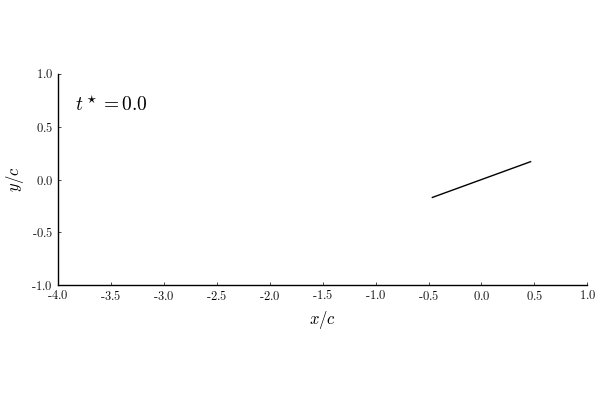

In [122]:
gif(anim, "/media/mat/HDD/NlVortexAssim/notebooks/enkf_50sensors.gif", fps = 5)

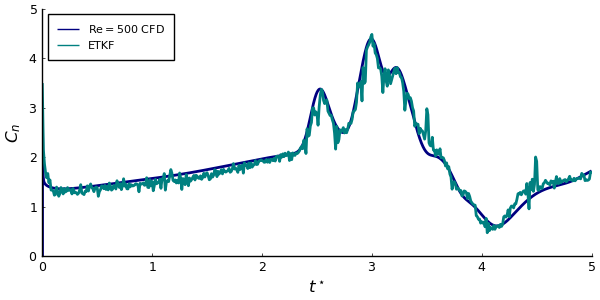

In [35]:
# Generate normal force response
fn = regen_forces(T, map(Xi->vcat(mean(Xi; dims = 2), config.tesp), Xa), config)[1:end-1];
plot(thist, 2Fn, label = "\$\\mathrm{Re} = 500\$ CFD", xlim = (0,tf), ylim = (0, 5), 
     linewidth = 2, legend = :topleft, color = ccfd)

# #Without median filtering
plot!(T, 2abs.(fn), label = "ETKF", ylabel="\$C_n\$", xlabel = L"t^\star", size = (600, 300),
linewidth = 2, color = cenkf)

# savefig("force_50sensors.pdf")

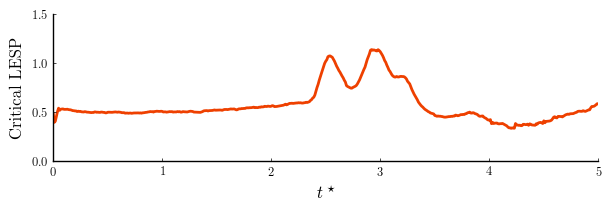

In [144]:
plot(T, map(Xi ->mean(Xi; dims = 2)[end], Xa)[1:end-1], legend = false,
    xlabel = L"t^\star", ylabel = "Critical LESP", linewidth = 2, size = (600, 200),
    xlim = (0, Inf), ylim = (0, 1.5), color = cetkf)
savefig("lespc_50sensors.pdf")

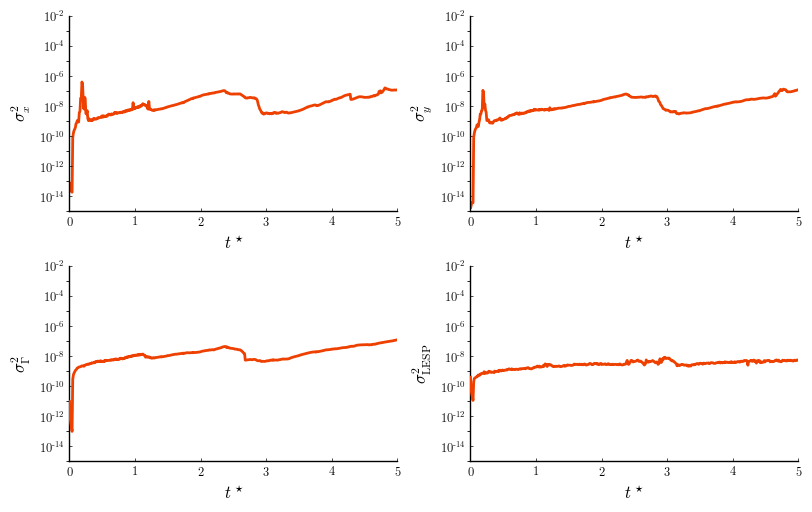

In [152]:
plt = plot(layout = (2,2), size = (800, 500), legend = false, xlim = (-Inf, Inf))
plot!(plt[1], T, map(cova) do P
        mean(diag(P)[1:3:end-1]) + eps()
    end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = L"t^\star",
ylabel = "\$\\sigma_x^2\$", color = cetkf)
plot!(plt[2], T, map(cova) do P
        mean(diag(P)[2:3:end-1]) + eps()
    end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = L"t^\star",
ylabel = "\$\\sigma_y^2\$", color = cetkf)
plot!(plt[3],T,  map(cova) do P
        mean(diag(P)[3:3:end-1]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = L"t^\star",
ylabel = "\$\\sigma_\\Gamma^2\$", color = cetkf)
plot!(plt[4], T, map(cova) do P
        mean(diag(P)[end]) + eps()
        end, ylim = (1e-15, 1e-2), yscale = :log10, linewidth = 2, xlabel = L"t^\star",
ylabel = "\$\\sigma_\\mathrm{LESP}^2\$", color = cetkf)

savefig("covariance_50sensors.pdf")

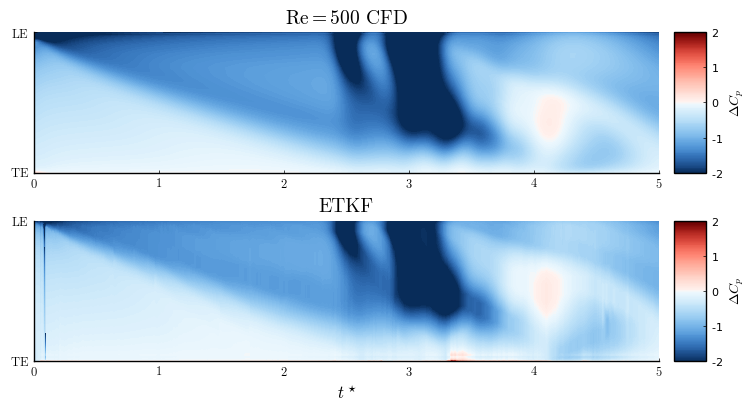

In [158]:
# Compare spatiotemporal pressure maps
let s = [-0.5config.L*cos(θ) for θ in range(0.0, stop = π, length = config.N)][pressure_taps],
    model_pressures = hcat((measure_state(vcat(mean(Xa[i+1]; dims = 2),config.tesp), t, config, pressure_taps) for (i,t) in enumerate(T))...),
    filtmodel_pressures = hcat((cleansignal(7)(measure_state(vcat(mean(Xa[i+1]; dims = 2),config.tesp), t, config, pressure_taps)) for (i,t) in enumerate(T))...),
    cfd_pressures = hcat((cfd_pressure(t, pressure_taps, config, pressure_data) for t in T)...)

    plt = plot(layout = (2,1), size = (800, 400))
    contourf!(T, s, [cfd_pressures,filtmodel_pressures], 
        title = ["\$\\mathrm{Re} = 500\$ CFD" "ETKF"],
        levels = range(-2.0, stop  = 2.0, length = 151), clims = (-2, 2), color = cgrad(reverse(colormap("RdBu"))), xlabel = ["" L"t^\star"],
        yticks = ([0.5, -0.5], ["LE", "TE"]), background_color_inside = colormap("RdBu")[end], colorbar_title= L"\Delta C_p")
end

savefig("pressure_50sensors.pdf")